In [1]:
import configparser
import datetime
import glob
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
from scipy import stats
import seaborn as sns
import subprocess
import sys

import matplotlib

import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker


sys.path.append("/dors/capra_lab/users/fongsl/tools/py_")

import config_readwrite as crw
import split_filename
import fet

# get plotting scripts

In [2]:
import plot_params as pp

pp.fonts()  # load font parameters
summary_labels = pp.summary_labels()  # get categorical labels for activity codes

# load config 

## analysis config 

In [3]:
name = "/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/config"
config, configfile_name = crw.read_config(name)

# read
FILES = config["PHASTCONS"]["path"]
BIN = config["PHASTCONS"]["bin"]

RE = config["PHASTCONS"]["RESULTS"]
MSAWAY = config["PHASTCONS"]["way"]

REGIONS = config["CIS_TRANS"]["regions"]
ANNOT = config["CIS_TRANS"]["regions_annotations"]
SHUFFLES = config["SHUFFLES"]["shuf-all"]

TE = config["REPEATMASKER"]["te_data_hg38"]

# read annotations

In [4]:
annot = pd.read_csv(ANNOT, sep = '\t')

print(annot.shape)
annot.head()

(16897, 26)


,#chr,start,end,region_id,conserved_active.regions,cis,trans,trans_only,cis_only,cis+trans,...,HH-active_MM-inactive_MH-inactive_cis,HH-active_MM-inactive_HM-inactive_trans,HH-active_MM-inactive_cis-only,HH-active_MM-inactive_trans-only,HH-active_MM-inactive_cis+trans,MM-active_HH-inactive_HM-inactive_cis,MM-active_HH-inactive_MH-inactive_trans,MM-active_HH-inactive_cis-only,MM-active_HH-inactive_trans-only,MM-active_HH-inactive_cis+trans
0,chr1,959034,959154,chr1:959034-959154,0.0,1.0,1.0,0,0,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,chr1,1002089,1002179,chr1:1002089-1002179,0.0,1.0,1.0,0,0,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,chr1,1064140,1064260,chr1:1064140-1064260,0.0,1.0,0.0,0,1,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr1,1214948,1215208,chr1:1214948-1215208,0.0,1.0,1.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,chr1,1215328,1215508,chr1:1215328-1215508,0.0,1.0,0.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


# functions

In [5]:
def getRegionIds(col, annot):
    region_list = annot.loc[annot[col]==1, "region_id"]
    
    return region_list

def getLabelCount(region_list, df, col_name, bootstrap_bool, nbootstraps):

    if bootstrap_bool is True:
        in_annot, out_annot = [], []
        for n in range(nbootstraps):
            test = df.loc[df["bin_id"].isin(region_list)].sample(n=len(region_list), replace=True)
        
            # within set, how many elements have annotation, or don't.
            in_annot.append(test.loc[test[col_name]==1].shape[0])
            out_annot.append(test.loc[test[col_name]!=1].shape[0])
    
    # no bootstrapping.
    else:
        # get dataset for region_list
        test = df.loc[df["bin_id"].isin(region_list)]

        # within set, how many elements have annotation, or don't.
        in_annot = test.loc[test[col_name]==1].shape[0]
        out_annot = test.loc[test[col_name]!=1].shape[0]

    return in_annot, out_annot

In [6]:
def intersect_w_phastcons(phastcons_bin, bed, genome_build, msaway, outdir):
    
    cmd = f"python {phastcons_bin} -b {bed} -g {genome_build} -m {msaway} -o {outdir}"
    print(cmd)
    subprocess.call(cmd, shell=True)

In [7]:
def calculateEmpiricalP(obs, exp_sum_list):
    """
    return two lists
        (1) info - vector w/  
                n_obs, 
                median_exp, 
                std, 
                fold-change  # calculated from the median of expected shuffle 
                p_val
                
        (2) fold_changes- vector expected fold changes (to calculate confidence interval)
        
    input
        observed overlap count (int)
        list of expected overlap counts (list of ints)
    
    method
        1. get median of expected overlap counts
        2. get standard deviation of expected overlap counts
        3. center expected overlap counts at median
        4. Sum the number of centered expected counts greater than observed centered count
            This is two tailed because it evaluates both sides of the distribution (w/ abs value). 
        5. calculate fold change as observed/ median expected w/ pseudo count
        6. calculate fold change of each "obs"/ expected w/ pseudo count
        7. calculate the p-value as count of equal or more extreme values than observed value
        8. return list of empirical info + fold changes
        
        
    
    """
    #1 median of exp distribution
    mu = np.median(exp_sum_list)  
    
    #2 std
    sigma = np.std(exp_sum_list)  
    
    #3 center at median of distribution 
    dist_from_mu = [exp - mu for exp in exp_sum_list]  
    
    #4 # count values >= centered obs
    p_sum = sum(1 for exp_dist in dist_from_mu if abs(exp_dist) >= abs(obs - mu)) 

    #5 fold change obs from median expected w pseudo count
    fold_change = (obs + 1.0) / (mu + 1.0) 
    
    #6 fold change obs from /each exp w pseudo count
    fold_changes = list((obs + 1.0) / (m + 1.0) for m in exp_sum_list) 
    
    #7 probability of observing obs-like value 
    # equal or more extreme in expected distribution
    p_val = (p_sum + 1.0) / (len(exp_sum_list) + 1.0)  
    
    #8
    info = [
            obs, 
            mu, 
            sigma, 
            fold_change, 
            p_val, 
            str(datetime.datetime.now())
            ]
    
    #return info, fold_changes
    return p_val

# phastcons intersection

In [8]:
BIN = "/home/fongsl/tools/evo/phastCons.py"

"""
bedtools intersect -a /data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/regions/all_uniq_diffAct_regions2.bed -b phastcons.30way.hg38.bed -c > all_uniq_diffAct_regions2_phastcons-30way.bed
"""

#intersect_w_phastcons(BIN, REGIONS, "hg38", MSAWAY, FILES)
#intersect_w_phastcons(BIN, SHUFFLES, "hg38", MSAWAY, FILES)

'\nbedtools intersect -a /data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/regions/all_uniq_diffAct_regions2.bed -b phastcons.30way.hg38.bed -c > all_uniq_diffAct_regions2_phastcons-30way.bed\n'

# Make joined DF

## open PHASTCONS, open ACTIVITY DF, merge on bins

In [9]:
fs = glob.glob(os.path.join(FILES, "*.bed"))

results = {}
shuf_keys = {}

for f in fs:
    if "Act" in f:
    
        # get names
        path, region_file, region = split_filename.split_filename(f)

        df = pd.read_csv(f, sep = '\t', header = None)  # read phastCons file

        # rname columns
        cols = ["#chr", "start", "end", "bin_id", "phastcons"]
        df.columns = cols  # rename the columns

        # create phastcons binary col
        df['phastbin']=0
        df.loc[df["phastcons"]>1, "phastbin"]=1 # make a binary col 

        # mark shuffle or not shuffled
        df["shuffle"] = region  # rename column

        # if this is the test dataframe, merge w/ region info
        if "all_uniq_diffAct_regions2_phastcons-30way" in f:
            #df = pd.merge(df, annot, how = "left")
            results[region] = df
        else:

            shuf_keys[region] = df

## Shuffles

In [10]:
shufs = pd.concat(shuf_keys.values()).drop_duplicates()

print(shufs.shape)

shufs.head()

(168970, 7)


,#chr,start,end,bin_id,phastcons,phastbin,shuffle
0,chr5,115170417,115170537,chr1:959034-959154,0,0,shuf-all_uniq_diffAct_regions2-all_phastcons-3...
1,chr4,37686249,37686339,chr1:1002089-1002179,1,0,shuf-all_uniq_diffAct_regions2-all_phastcons-3...
2,chr20,32762661,32762781,chr1:1064140-1064260,1,0,shuf-all_uniq_diffAct_regions2-all_phastcons-3...
3,chr7,98133420,98133680,chr1:1214948-1215208,2,1,shuf-all_uniq_diffAct_regions2-all_phastcons-3...
4,chr1,84689773,84689953,chr1:1215328-1215508,0,0,shuf-all_uniq_diffAct_regions2-all_phastcons-3...


In [11]:
df = results["all_uniq_diffAct_regions2_phastcons-30way"]
print(df.shape)
df.head()

(16897, 7)


,#chr,start,end,bin_id,phastcons,phastbin,shuffle
0,chr1,959034,959154,chr1:959034-959154,1,0,all_uniq_diffAct_regions2_phastcons-30way
1,chr1,1002089,1002179,chr1:1002089-1002179,0,0,all_uniq_diffAct_regions2_phastcons-30way
2,chr1,1064140,1064260,chr1:1064140-1064260,0,0,all_uniq_diffAct_regions2_phastcons-30way
3,chr1,1214948,1215208,chr1:1214948-1215208,0,0,all_uniq_diffAct_regions2_phastcons-30way
4,chr1,1215328,1215508,chr1:1215328-1215508,0,0,all_uniq_diffAct_regions2_phastcons-30way


# PhastCons v. inactive, accessible shuffles 

## FET for PhastCons enrichment

       phastcons overlap.   no phastcons  overlap
    AS      A.         B
    shuf    C.         D

In [43]:
rdict = {}
phasttest = df.loc[df.phastcons == 1]
phastshuf = shufs.loc[shufs.phastcons == 1]

test_cols =[
            'conserved_active.regions',    
            'cis_only', "trans_only", "cis+trans",
            'HH-active_MM-inactive_cis-only',
            'HH-active_MM-inactive_trans-only',
            'HH-active_MM-inactive_cis+trans',
            'MM-active_HH-inactive_cis-only',
            'MM-active_HH-inactive_trans-only',
            'MM-active_HH-inactive_cis+trans',
]

d,c = (shufs["phastbin"].shape[0] - shufs["phastbin"].sum()), shufs["phastbin"].sum()
for t in test_cols:
    pos = getRegionIds(t, annot)
    test = df.loc[df["bin_id"].isin(pos)]
    test_shuf = shufs.loc[shufs["bin_id"].isin(pos)]
    a = test["phastbin"].sum()
    b = test.shape[0]-a
    c = test_shuf["phastbin"].sum()
    d = test_shuf.shape[0] - c
    
    results = fet.get_2x2(a,b,c,d,t)
    results["col"]= t
    rdict[t] = results


# FDR correction
fdr = fet.fdr_correction(rdict)
fdr["frac"] = fdr["a"]/ (fdr["a"]+ fdr["b"])
fdr["frac_shuf"] = fdr["c"]/ (fdr["c"]+ fdr["d"])
fdr

[[1040, 1994], [6641, 23699]]
conserved_active.regions [[1040, 1994], [6641, 23699]] 1.8612500655104902 9.56032643670525e-50
[[371, 1783], [3090, 18450]]
cis_only [[371, 1783], [3090, 18450]] 1.2423971815800794 0.0004278481531734755
[[403, 1580], [2812, 17018]]
trans_only [[403, 1580], [2812, 17018]] 1.5436227199884762 1.5873188058157286e-12
[[885, 7740], [10044, 76206]]
cis+trans [[885, 7740], [10044, 76206]] 0.867530540042418 0.0001068069017890063
[[230, 884], [1610, 9530]]
HH-active_MM-inactive_cis-only [[230, 884], [1610, 9530]] 1.5400775694893343 1.1805676694621366e-07
[[195, 617], [1153, 6967]]
HH-active_MM-inactive_trans-only [[195, 617], [1153, 6967]] 1.9097035286708903 2.543369572859642e-12
[[556, 4075], [5303, 41007]]
HH-active_MM-inactive_cis+trans [[556, 4075], [5303, 41007]] 1.0550755273378074 0.2563499128457434
[[141, 899], [1480, 8920]]
MM-active_HH-inactive_cis-only [[141, 899], [1480, 8920]] 0.9452845504013468 0.5759825970582471
[[208, 963], [1659, 10051]]
MM-active_HH

,a,b,c,d,OR,P,ci_lower,ci_lower_diff,ci_upper,ci_upper_diff,...,ci_lower_log2,ci_upper_log2,comparison,col,reject_null,FDR_P,asterisks,-log10p,frac,frac_shuf
0,1040,1994,6641,23699,1.861250,9.560326e-50,1.718572,0.115061,2.015773,0.115061,...,0.781211,1.011333,conserved_active.regions,conserved_active.regions,True,9.560326e-49,*,48.019527,0.342782,0.218886
0,371,1783,3090,18450,1.242397,4.278482e-04,1.103944,0.170459,1.398215,0.170459,...,0.142667,0.483586,cis_only,cis_only,True,6.112116e-04,*,3.213808,0.172238,0.143454
0,403,1580,2812,17018,1.543623,1.587319e-12,1.373971,0.167969,1.734223,0.167969,...,0.458351,0.794289,trans_only,trans_only,True,5.291063e-12,*,11.276457,0.203227,0.141805
0,885,7740,10044,76206,0.867531,1.068069e-04,0.806785,0.104730,0.932850,0.104730,...,-0.309744,-0.100283,cis+trans,cis+trans,True,1.780115e-04,*,3.749552,0.102609,0.116452
0,230,884,1610,9530,1.540078,1.180568e-07,1.319749,0.222739,1.797189,0.222739,...,0.400264,0.845742,HH-active_MM-inactive_cis-only,HH-active_MM-inactive_cis-only,True,2.361135e-07,*,6.626879,0.206463,0.144524
0,195,617,1153,6967,1.909704,2.543370e-12,1.606882,0.249085,2.269593,0.249085,...,0.684264,1.182434,HH-active_MM-inactive_trans-only,HH-active_MM-inactive_trans-only,True,6.358424e-12,*,11.196651,0.240148,0.141995
0,556,4075,5303,41007,1.055076,2.563499e-01,0.961270,0.134332,1.158035,0.134332,...,-0.056986,0.211679,HH-active_MM-inactive_cis+trans,HH-active_MM-inactive_cis+trans,False,2.848332e-01,None,0.545409,0.120060,0.114511
0,141,899,1480,8920,0.945285,5.759826e-01,0.784955,0.268138,1.138362,0.268138,...,-0.349318,0.186959,MM-active_HH-inactive_cis-only,MM-active_HH-inactive_cis-only,False,5.759826e-01,None,0.239591,0.135577,0.142308
0,208,963,1659,10051,1.308579,1.088246e-03,1.116655,0.228818,1.533490,0.228818,...,0.159183,0.616819,MM-active_HH-inactive_trans-only,MM-active_HH-inactive_trans-only,True,1.360307e-03,*,2.866363,0.177626,0.141674
0,329,3665,4741,35199,0.666473,1.194817e-12,0.592999,0.168516,0.749050,0.168516,...,-0.753898,-0.416867,MM-active_HH-inactive_cis+trans,MM-active_HH-inactive_cis+trans,True,5.291063e-12,*,11.276457,0.082374,0.118703


## plotting functions

In [44]:
def annotate_bar(graph, ax, annot, height):

    if ax == "x":
    
        for p, a in zip(graph.patches, annot):

            graph.annotate(a, 
                            (p.get_x() + p.get_width() / 2.0, height),
                            #p.get_height()-1), 
                            ha = 'center', 
                            va = 'center', 
                            xytext = (0, 5),
                            textcoords = 'offset points')

def plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title, figsize):
    if figsize == None:
        fig, ax = plt.subplots(figsize=(6,6))
    else:
        fig, ax = plt.subplots(figsize=figsize)
        
    
    # get difference between y and upper/lower CI for plotting. 
    l = np.array(data[y]-data[ci_lower])
    u = np.array(data[ci_upper]- data[y])
             
    yerr = [l, u]

    sns.barplot(
            x=x, y=y, data=data,
            #order = order,
            #hue = hue,
            linewidth=2.5, 
            #facecolor=(1, 1, 1, 0),
            edgecolor=".2",
            yerr=yerr
            )
   
    plt.axhline(0, color = "grey", linewidth = 2.5)  # plot a line at zero


    #ax.set_xticklabels(["Complex\nEnhancer", "Simple\nEnhancer", "Complex\nEnhancer\nCore v. Derived"])

    ax.set_xlabel("")

    #ax.get_yaxis().ticker.LogLocator(base=2)

    # set the y ticks
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(2**x))
    ax.yaxis.set_major_formatter(ticks)
    ax.yaxis.set_major_locator(MultipleLocator(ytick_multiple))
    ax.set(
        xlabel = "",
        ylabel="Odds ratio\n(scaled log2)",  # y label
        title = title,
        ylim=ylim)
    return fig, ax



## groups for plotting

In [45]:
plot_sets = {
            "all":
                ['cis_only', 'trans_only', "cis+trans","conserved_active.regions", ],
            "main_fig":
                [ 'cis_only','trans_only', "cis+trans"],
            "main_fig_all":
                [ "conserved_active.regions", 'cis_only','trans_only', "cis+trans", 
                 'HH-active_MM-inactive_cis-only','HH-active_MM-inactive_trans-only','HH-active_MM-inactive_cis+trans',
                 'MM-active_HH-inactive_cis-only','MM-active_HH-inactive_trans-only','MM-active_HH-inactive_cis+trans'
                ],
            "HH-active_MM-inactive":
                ['HH-active_MM-inactive_cis-only','HH-active_MM-inactive_trans-only','HH-active_MM-inactive_cis+trans'],
            "MM-active_HH-inactive":
                ['MM-active_HH-inactive_cis-only','MM-active_HH-inactive_trans-only','MM-active_HH-inactive_cis+trans']
            }

## plot results

['cis_only', 'trans_only', 'cis+trans', 'conserved_active.regions']
['cis_only', 'trans_only', 'cis+trans']
['conserved_active.regions', 'cis_only', 'trans_only', 'cis+trans', 'HH-active_MM-inactive_cis-only', 'HH-active_MM-inactive_trans-only', 'HH-active_MM-inactive_cis+trans', 'MM-active_HH-inactive_cis-only', 'MM-active_HH-inactive_trans-only', 'MM-active_HH-inactive_cis+trans']
['HH-active_MM-inactive_cis-only', 'HH-active_MM-inactive_trans-only', 'HH-active_MM-inactive_cis+trans']
['MM-active_HH-inactive_cis-only', 'MM-active_HH-inactive_trans-only', 'MM-active_HH-inactive_cis+trans']


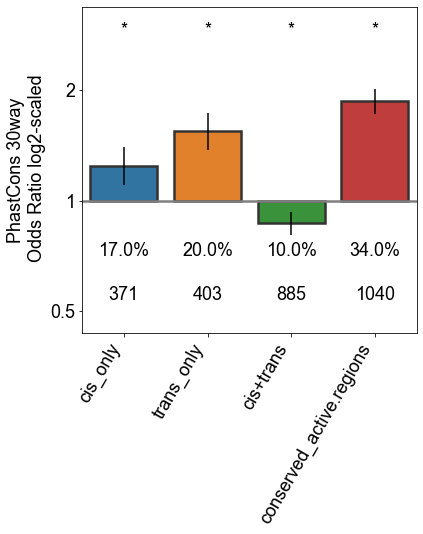

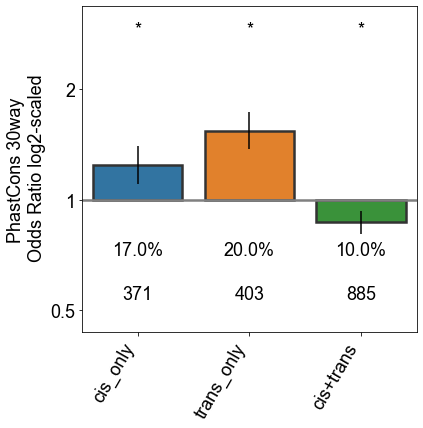

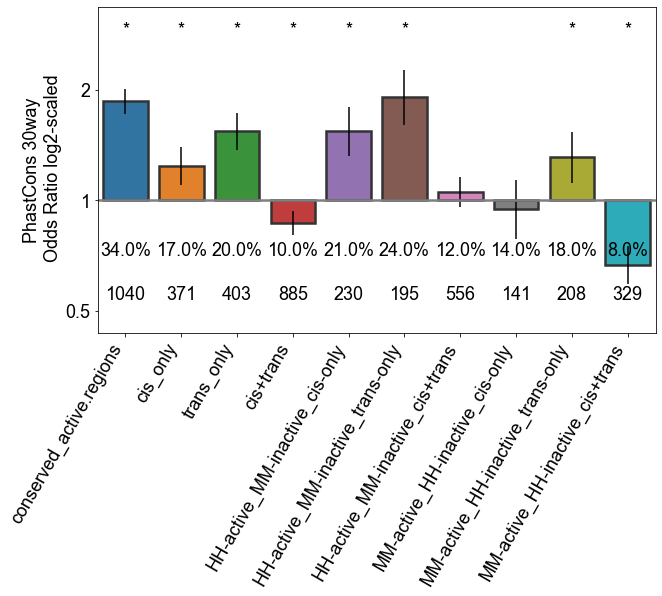

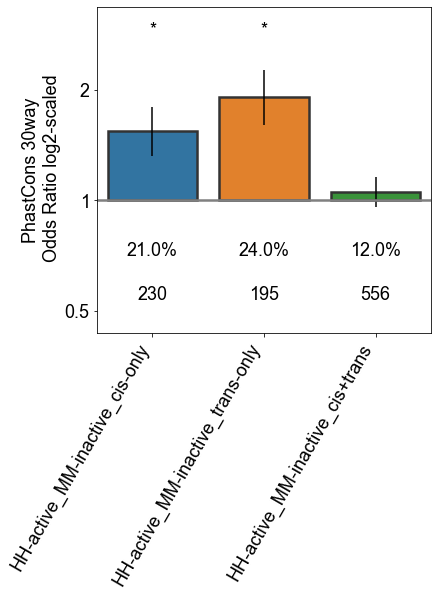

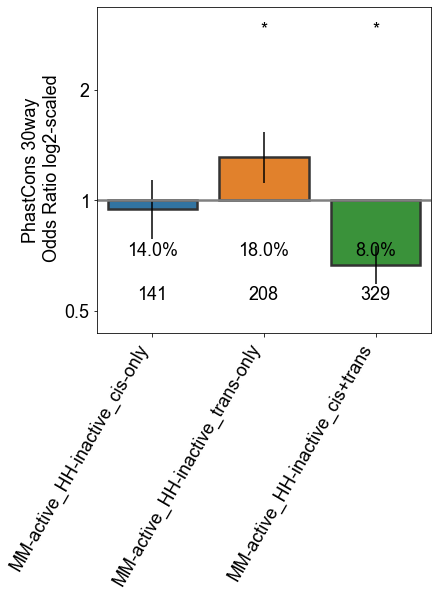

In [46]:
for key, value in plot_sets.items():
    print(value)
 
    x,y ="comparison", "OR_log2"
    
    data = fdr.loc[fdr["comparison"].isin(value)]
    data = data.set_index("comparison")
    data = data.loc[value].reset_index()
    ci_upper, ci_lower= "ci_upper_log2","ci_lower_log2"

    ytick_multiple = 1
    ylim = (-1.2,1.75)
    title = ""#f"{key}"

    hue = None
    
    if key =="main_fig_all":
        figsize=(10,6)
    else:
        figsize=None

    # plot
    fig, ax = plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title, figsize)

    ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, horizontalalignment = "right")
    ax.set( ylabel = "PhastCons 30way\n Odds Ratio log2-scaled"
        #xticklabels = ["Conserved activity", "Trans", "Cis", "Cis and trans"]
    )
    plotc = data["a"].astype(int)
    annotate_bar(ax, "x", plotc, -0.9)
    plota = data["asterisks"]
    annotate_bar(ax, "x", plota, 1.5)
    plota = data["frac"].round(2).apply(lambda x: str(round(x*100, 2))+"%")
    annotate_bar(ax, "x", plota, -0.5)

    outf = os.path.join(RE, f"phastCons_enrichment_{key}_v_10x_shuffle_validation.pdf")

    plt.savefig(outf, bbox_inches = "tight")

## plot fraction

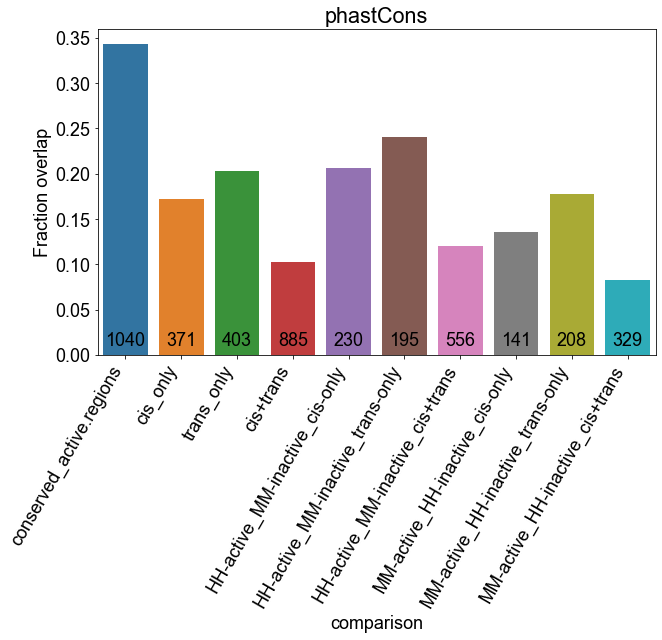

In [16]:
x, y = "comparison", "frac"
order = test_cols#"cons_act", "trans_only", "cis_only",  "hu_cis_and_trans"]
data = fdr.set_index("comparison").loc[order].reset_index()
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x=x,y=y,data=data )
ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, horizontalalignment = "right")

ax.set(
    title = "phastCons",
    ylabel = "Fraction overlap",
    #xticklabels = ["Conserved activity", "Trans", "Cis", "Cis and trans"]
)

plotc = data["a"].astype(int)
annotate_bar(ax, "x", plotc, 0.01)

outf = os.path.join(RE, "phastCons_frac_validation.pdf")

plt.savefig(outf, bbox_inches = "tight")

# comparing HH ORs
- boostrap OR differences between two groups.

## bootstrap HH-only cis OR v. trans OR

In [17]:
out = os.path.join(RE, "boostrap_HH_cis.trans.10k.tsv")

collection={}

cols = [
    ('HH-active_MM-inactive_trans-only'),
    ('HH-active_MM-inactive_cis-only')
    ]

nbootstrap = 10000

if os.path.exists(out) is False:
    

    # BS, compute 2x2
    for col in cols:

        # get the region_ids that are HH/MM active
        regions_list = getRegionIds(col, annot)

        test_annotation = "phastbin"

        # bootstrap test annotation overlap 100 times
        bootstrap = True

        # bootstrap shuf test annotation overlap
        in_annot_bsshuf, out_annot_bsshuf = getLabelCount(regions_list, shufs, test_annotation, bootstrap, nbootstrap)

        # closed counts
        bootstrap = False
        in_closed, out_closed = getLabelCount(regions_list, df, test_annotation, bootstrap, nbootstrap)
        in_closed_shuf, out_closed_shuf = getLabelCount(regions_list, shufs, test_annotation, bootstrap, nbootstrap)

        # closed counts shuf

        # collect bootstrapped ORS
        ORS={}

        # get bootstrap ORS
        for i in range(nbootstrap):
            t = f"{col}.v.{col}-shuf.{i}"
            a, b = in_closed, out_closed 
            c, d = in_annot_bsshuf[i], out_annot_bsshuf[i]
            results = fet.get_2x2(a,b,c,d,t)
            results["iter"] = i
            ORS[t]= results

        # get closed OR
        i="closed"
        t = f"{col}.v.{col}-shuf.{i}"
        a,b = in_closed, out_closed
        c,d = in_closed_shuf, out_closed_shuf
        results = fet.get_2x2(a,b,c,d,t)
        results["iter"] = i
        ORS[t]= results

        # list of ORS
        results_ = pd.concat(ORS.values())
        collection[col]=results_

    # save the bootstraps
    collectiondf = pd.concat(collection.values())
    collectiondf.to_csv(out, sep='\t', index=False)
else:
    # laod the bootstraps
    collectiondf = pd.read_csv(out, sep='\t')

# compute test and shuffled fraction overlap
collectiondf["test_frac"] = (collectiondf["a"]/(collectiondf["a"]+collectiondf["b"]))
collectiondf["shuf_frac"] = (collectiondf["c"]/(collectiondf["c"]+collectiondf["d"]))

###  bootstrap results

In [18]:
# split in 2
label1, label2='HH-active_MM-inactive_trans-only', 'HH-active_MM-inactive_cis-only'

d1 = collectiondf.loc[collectiondf["comparison"].str.contains(label1)]
dist1 = d1.loc[d1["iter"]!="closed"]["OR"]
closed1 = d1.loc[d1["iter"]=="closed"]["OR"].iloc[0]

d2 = collectiondf.loc[collectiondf["comparison"].str.contains(label2)]
dist2 = d2.loc[d2["iter"]!="closed"]["OR"]
closed2 = d2.loc[d2["iter"]=="closed"]["OR"].iloc[0]

dif_or = closed1- closed2
d1.head()

,a,b,c,d,OR,P,ci_lower,ci_lower_diff,ci_upper,ci_upper_diff,OR_log2,ci_lower_log2,ci_upper_log2,comparison,iter,test_frac,shuf_frac
0,195,617,123,689,1.770368,8.413818e-06,1.378123,0.361344,2.274254,0.361344,0.824049,0.462705,1.185394,HH-active_MM-inactive_trans-only.v.HH-active_M...,0,0.240148,0.151478
1,195,617,120,692,1.822528,3.145760e-06,1.416592,0.363517,2.344789,0.363517,0.865941,0.502424,1.229458,HH-active_MM-inactive_trans-only.v.HH-active_M...,1,0.240148,0.147783
2,195,617,129,683,1.673326,5.197081e-05,1.306257,0.357279,2.143542,0.357279,0.742718,0.385439,1.099997,HH-active_MM-inactive_trans-only.v.HH-active_M...,2,0.240148,0.158867
3,195,617,118,694,1.858775,1.587121e-06,1.443260,0.365021,2.393918,0.365021,0.894352,0.529331,1.259374,HH-active_MM-inactive_trans-only.v.HH-active_M...,3,0.240148,0.145320
4,195,617,104,708,2.151540,6.700208e-09,1.656758,0.377007,2.794085,0.377007,1.105369,0.728363,1.482376,HH-active_MM-inactive_trans-only.v.HH-active_M...,4,0.240148,0.128079


### plot OR bootstrap results

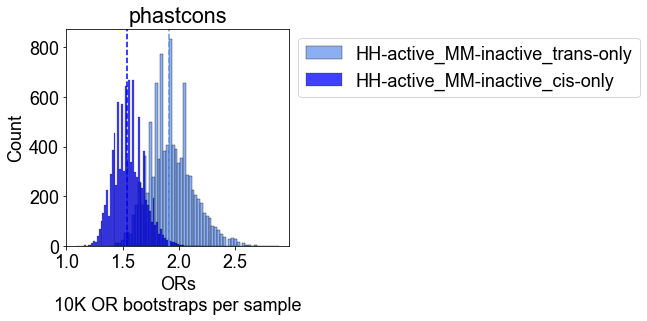

In [19]:
fig, ax = plt.subplots(figsize=(4,4))
sns.histplot(dist1, label = label1, color="cornflowerblue")
sns.histplot(dist2, color = "b", label=label2)
ax.axvline(closed1, color="cornflowerblue", ls ="--")
ax.axvline(closed2, color = "b", ls ="--")
ax.legend(bbox_to_anchor = (1,1))
ax.set(title="phastcons",
       xlabel = "ORs\n10K OR bootstraps per sample"
      )
outfig = os.path.join(RE, "HH_cis-only.trans-only.phastcons.OR.BS10k.pdf")
plt.savefig(outfig, bbox_inches="tight")

### ttest difference between distributions

In [20]:
stats.ttest_ind(dist1, dist2)

Ttest_indResult(statistic=158.021596285102, pvalue=0.0)

## frac dif

(10001, 17) (10001, 17)
0.5587


/home/fongsl/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


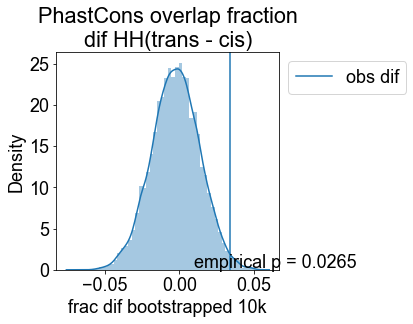

In [21]:
col = "shuf_frac"

difs = []
# 
obs = d1.loc[d1["iter"]=="closed", "test_frac"].iloc[0] - d2.loc[d2["iter"]=="closed", "test_frac"].iloc[0]

d1_=list(d1.loc[d1["iter"]!="closed", col])  # trans ors
d2_=list(d2.loc[d2["iter"]!="closed", col])  # cis ors

for one, two in zip(d1_,d2_):
    difs.append(one-two)  # dif between trans and cis

print(d1.shape, d2.shape)

d = pd.DataFrame(difs)

d["percentile"] = d[0].rank(pct=True)

print(d.loc[d[0]<=0, "percentile"].max())

fig, ax= plt.subplots(figsize=(4,4))
sns.distplot(difs, ax=ax)
ax.axvline(obs, label="obs dif")

ax.set(
    xlabel = "frac dif bootstrapped 10k",
title = "PhastCons overlap fraction\ndif HH(trans - cis)")
ax.legend(bbox_to_anchor = (1,1))

# calculate empirical p value
p1 = round(calculateEmpiricalP(obs, difs), 4)
ax.text(0.01,0.3, f"empirical p = {p1}")

outfig = os.path.join(RE, "dif-HH_cis-only.trans-only.phastcons.frac.BS10k.pdf")
plt.savefig(outfig, bbox_inches="tight")

In [22]:
# quantum barcoding
# 125chr1:1064140K - 150K nuclei, multibarcoding. 5k-10k cell 
# 3 barcodes per well. 

# CROP_seq
# CRISPR - ontarget/ off target quide capture. 

# Dif in frac exp v. obs: cis-only v. trans-only

In [23]:
out = os.path.join(RE, "boostrap_all_cis.trans.10k.tsv")

collection={}

cols = [
    'trans_only',
    'cis_only'
    ]

nbootstrap = 10000

if os.path.exists(out) is False:
    

    # BS, compute 2x2
    for col in cols:

        # get the region_ids that are HH/MM active
        regions_list = getRegionIds(col, annot)

        test_annotation = "phastbin"

        # bootstrap test annotation overlap 100 times
        bootstrap = True

        # bootstrap shuf test annotation overlap
        in_annot_bsshuf, out_annot_bsshuf = getLabelCount(regions_list, shufs, test_annotation, bootstrap, nbootstrap)

        # closed counts
        bootstrap = False
        in_closed, out_closed = getLabelCount(regions_list, df, test_annotation, bootstrap, nbootstrap)
        in_closed_shuf, out_closed_shuf = getLabelCount(regions_list, shufs, test_annotation, bootstrap, nbootstrap)

        # closed counts shuf

        # collect bootstrapped ORS
        ORS={}

        # get bootstrap ORS
        for i in range(nbootstrap):
            t = f"{col}.v.{col}-shuf.{i}"
            a, b =  in_closed, out_closed
            c, d = in_annot_bsshuf[i], out_annot_bsshuf[i]
            results = fet.get_2x2(a,b,c,d,t)
            results["iter"] = i
            ORS[t]= results

        # get closed OR
        i="closed"
        t = f"{col}.v.{col}-shuf.{i}"
        a,b = in_closed, out_closed
        c,d = in_closed_shuf, out_closed_shuf
        results = fet.get_2x2(a,b,c,d,t)
        results["iter"] = i
        ORS[t]= results

        # list of ORS
        results_ = pd.concat(ORS.values())
        collection[col]=results_

    # save the bootstraps
    collectiondf = pd.concat(collection.values())
    collectiondf.to_csv(out, sep='\t', index=False)
else:
    # laod the bootstraps
    collectiondf = pd.read_csv(out, sep='\t')

# compute test and shuffled fraction
collectiondf["test_frac"] = (collectiondf["a"]/(collectiondf["a"]+collectiondf["b"]))
collectiondf["shuf_frac"] = (collectiondf["c"]/(collectiondf["c"]+collectiondf["d"]))


In [24]:

label1, label2='trans_only', 'cis_only'

d1 = collectiondf.loc[collectiondf["comparison"].str.contains(label1)]
dist1 = d1.loc[d1["iter"]!="closed"]["OR"]
closed1 = d1.loc[d1["iter"]=="closed"]["OR"].iloc[0]

d2 = collectiondf.loc[collectiondf["comparison"].str.contains(label2)]
dist2 = d2.loc[d2["iter"]!="closed"]["OR"]
closed2 = d2.loc[d2["iter"]=="closed"]["OR"].iloc[0]

## differences in the fraction of overlaps. 
- background is the difference of fractions between shuffled trans and shuffled cis dataset (trans frac - cis frac) from 10k bootstrapped sampled. 

- obs difference in fractions between trans and cis overlaps with PhastCons. 

(10001, 17) (10001, 17)
0.5658


/home/fongsl/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


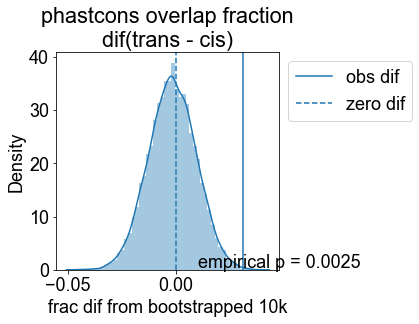

In [25]:
col = "shuf_frac"

difs = []
# 
obs = d1.loc[d1["iter"]=="closed", "test_frac"].iloc[0] - d2.loc[d2["iter"]=="closed", "test_frac"].iloc[0]

d1_=list(d1.loc[d1["iter"]!="closed", col])  # trans ors
d2_=list(d2.loc[d2["iter"]!="closed", col])  # cis ors

for one, two in zip(d1_,d2_):
    difs.append(one-two)  # dif between trans and cis

print(d1.shape, d2.shape)

d = pd.DataFrame(difs)

d["percentile"] = d[0].rank(pct=True)

print(d.loc[d[0]<=0, "percentile"].max())

fig, ax= plt.subplots(figsize=(4,4))
sns.distplot(difs, ax=ax)
ax.axvline(obs, label="obs dif")
ax.axvline(0, ls = "--", label="zero dif")
ax.set(
    xlabel = "frac dif from bootstrapped 10k",
    title = "phastcons overlap fraction\ndif(trans - cis)")
ax.legend(bbox_to_anchor = (1,1))

# calculate empirical p value
p1 = round(calculateEmpiricalP(obs, difs), 4)
ax.text(0.01,0.3, f"empirical p = {p1}")

outfig = os.path.join(RE, "dif_cis-only.trans-only.phastcons.frac.BS10k.pdf")
plt.savefig(outfig, bbox_inches="tight")

# TE

## load TE data

In [29]:
def assignCoor(df, name):
    df[name] = df["#chr"]+":"+ df["start"].map(str) + "-"+ df["end"].map(str)
    
    return df

In [30]:
# load TE overlaps
te = pd.read_csv(TE, sep='\t')

# set of te-overlapping region_ids
te_overlap = set(te.loc[te["te_count-hg38"]>0, "region_id"])

# load shuffle TE overlaps
TE_PATH = config["REPEATMASKER"]["path"]

# set of te-overlapping shuffled region_ids
te_shuf_overlap=set()
shuf_files = glob.glob(os.path.join(TE_PATH, "shuf-all_uniq_diffAct_regions2-*_TE-cleaned.bed"))

for i, shuf in enumerate(shuf_files):
    shuf_df = pd.read_csv(shuf, sep = '\t')
    shuf_df=assignCoor(shuf_df, "shuf_id")
    te_shuf_overlap.update(set(shuf_df.loc[shuf_df["te_count-hg38"]>0, "shuf_id"]))


## integrate TE annotations with phastcons data

In [31]:
def assignTE(df, overlap_set, col):
    
    df["te"]=False
    df.loc[df[col].isin(overlap_set), 'te'] = True
    
    return df

In [32]:
df = assignTE(df, te_overlap, "bin_id")
shufs = assignCoor(shufs, "shuf_id")
shufs =assignTE(shufs, te_shuf_overlap, "shuf_id")

## test phastcons enrichment, removing TE-overlapping elements

In [33]:
rdict = {}
phasttest = df.loc[(df.phastcons == 1) & (df.te == False)]
phastshuf = shufs.loc[(shufs.phastcons == 1) & (shufs.te == False)]

test_cols =[
            'conserved_active.regions',    
            'cis_only', "trans_only", "cis+trans",
            'HH-active_MM-inactive_cis-only',
            'HH-active_MM-inactive_trans-only',
            'HH-active_MM-inactive_cis+trans',
            'MM-active_HH-inactive_cis-only',
            'MM-active_HH-inactive_trans-only',
            'MM-active_HH-inactive_cis+trans',
]

d,c = (shufs["phastbin"].shape[0] - shufs["phastbin"].sum()), shufs["phastbin"].sum()

for t in test_cols:
    pos = getRegionIds(t, annot)
    test = df.loc[(df["bin_id"].isin(pos))& (df.te == False)]
    test_shuf = shufs.loc[(shufs["bin_id"].isin(pos))& (shufs.te == False)]
    a = test["phastbin"].sum()
    b = test.shape[0]-a
    c = test_shuf["phastbin"].sum()
    d = test_shuf.shape[0] - c
    
    results = fet.get_2x2(a,b,c,d,t)
    results["col"]= t
    rdict[t] = results


# FDR correction
fdr = fet.fdr_correction(rdict)
fdr["frac"] = fdr["a"]/ (fdr["a"]+ fdr["b"])
fdr["frac_shuf"] = fdr["c"]/ (fdr["c"]+ fdr["d"])
fdr

[[868, 1481], [4159, 12899]]
conserved_active.regions [[868, 1481], [4159, 12899]] 1.8177401043172645 1.8771183922526628e-36
[[324, 1340], [2284, 11831]]
cis_only [[324, 1340], [2284, 11831]] 1.2524649083827797 0.0008022239902535797
[[342, 1206], [2025, 10742]]
trans_only [[342, 1206], [2025, 10742]] 1.5043154597383452 1.6505291804149884e-09
[[790, 5582], [7562, 51302]]
cis+trans [[790, 5582], [7562, 51302]] 0.9601407061709195 0.3142064100534878
[[200, 709], [1206, 6160]]
HH-active_MM-inactive_cis-only [[200, 709], [1206, 6160]] 1.4408446717985064 3.653819911135186e-05
[[165, 445], [829, 4357]]
HH-active_MM-inactive_trans-only [[165, 445], [829, 4357]] 1.9487537441888834 9.613450441727738e-11
[[506, 3046], [3974, 27691]]
HH-active_MM-inactive_cis+trans [[506, 3046], [3974, 27691]] 1.1575277055291437 0.004486517590973731
[[124, 631], [1078, 5671]]
MM-active_HH-inactive_cis-only [[124, 631], [1078, 5671]] 1.0337921078242562 0.753607349504037
[[177, 761], [1196, 6385]]
MM-active_HH-inacti

,a,b,c,d,OR,P,ci_lower,ci_lower_diff,ci_upper,ci_upper_diff,...,ci_lower_log2,ci_upper_log2,comparison,col,reject_null,FDR_P,asterisks,-log10p,frac,frac_shuf
0,868,1481,4159,12899,1.817740,1.877118e-36,1.659995,0.130967,1.990476,0.130967,...,0.731179,0.993113,conserved_active.regions,conserved_active.regions,True,1.877118e-35,*,34.726508,0.369519,0.243815
0,324,1340,2284,11831,1.252465,8.022240e-04,1.100506,0.186603,1.425406,0.186603,...,0.138167,0.511373,cis_only,cis_only,True,1.337040e-03,*,2.873856,0.194712,0.161814
0,342,1206,2025,10742,1.504315,1.650529e-09,1.322094,0.186282,1.711652,0.186282,...,0.402825,0.775389,trans_only,trans_only,True,5.501764e-09,*,8.259498,0.220930,0.158612
0,790,5582,7562,51302,0.960141,3.142064e-01,0.887814,0.112989,1.038360,0.112989,...,-0.171671,0.054306,cis+trans,cis+trans,False,3.491182e-01,None,0.457027,0.123980,0.128466
0,200,709,1206,6160,1.440845,3.653820e-05,1.217263,0.243274,1.705493,0.243274,...,0.283641,0.770189,HH-active_MM-inactive_cis-only,HH-active_MM-inactive_cis-only,True,7.307640e-05,*,4.136223,0.220022,0.163725
0,165,445,829,4357,1.948754,9.613450e-11,1.605962,0.279114,2.364715,0.279114,...,0.683438,1.241666,HH-active_MM-inactive_trans-only,HH-active_MM-inactive_trans-only,True,4.806725e-10,*,9.318151,0.270492,0.159853
0,506,3046,3974,27691,1.157528,4.486518e-03,1.047593,0.143969,1.278999,0.143969,...,0.067078,0.355015,HH-active_MM-inactive_cis+trans,HH-active_MM-inactive_cis+trans,True,6.409311e-03,*,2.193189,0.142455,0.125501
0,124,631,1078,5671,1.033792,7.536073e-01,0.843656,0.293220,1.266780,0.293220,...,-0.245274,0.341166,MM-active_HH-inactive_cis-only,MM-active_HH-inactive_cis-only,False,7.536073e-01,None,0.122855,0.164238,0.159727
0,177,761,1196,6385,1.241705,1.636272e-02,1.042538,0.252223,1.478921,0.252223,...,0.060099,0.564545,MM-active_HH-inactive_trans-only,MM-active_HH-inactive_trans-only,True,2.045340e-02,*,1.689235,0.188699,0.157763
0,284,2536,3588,23611,0.736938,1.461626e-06,0.648676,0.184046,0.837210,0.184046,...,-0.624431,-0.256338,MM-active_HH-inactive_cis+trans,MM-active_HH-inactive_cis+trans,True,3.654064e-06,*,5.437224,0.100709,0.131917


## plot

['cis_only', 'trans_only', 'cis+trans', 'conserved_active.regions']
['cis_only', 'trans_only', 'cis+trans']
['conserved_active.regions', 'cis_only', 'trans_only', 'cis+trans', 'HH-active_MM-inactive_cis-only', 'HH-active_MM-inactive_trans-only', 'HH-active_MM-inactive_cis+trans', 'MM-active_HH-inactive_cis-only', 'MM-active_HH-inactive_trans-only', 'MM-active_HH-inactive_cis+trans']
['HH-active_MM-inactive_cis-only', 'HH-active_MM-inactive_trans-only', 'HH-active_MM-inactive_cis+trans']
['MM-active_HH-inactive_cis-only', 'MM-active_HH-inactive_trans-only', 'MM-active_HH-inactive_cis+trans']


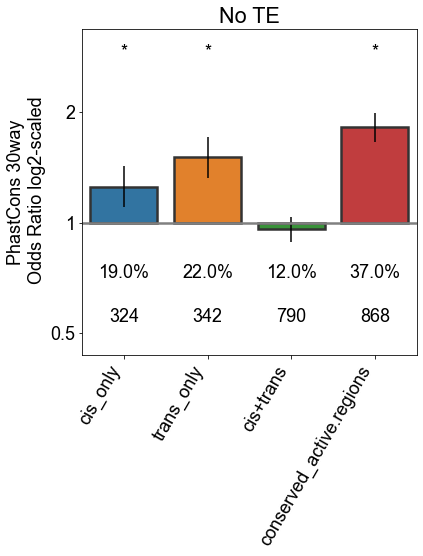

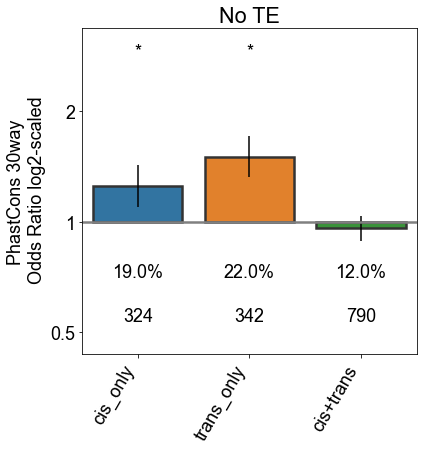

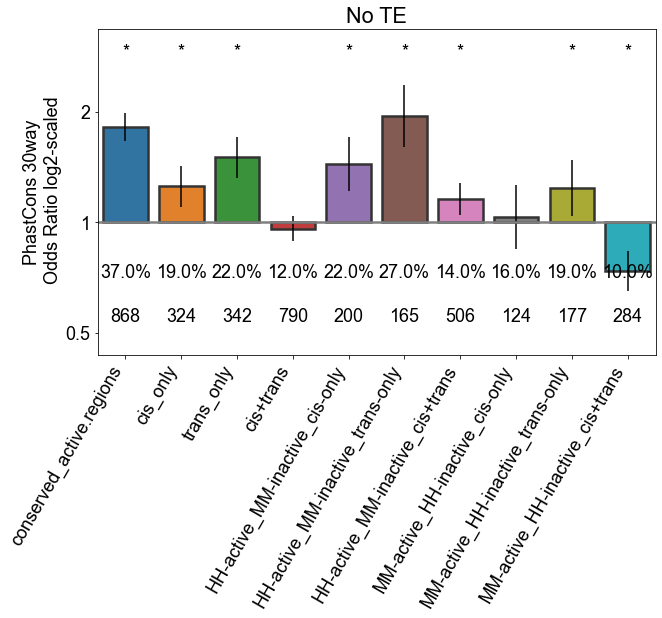

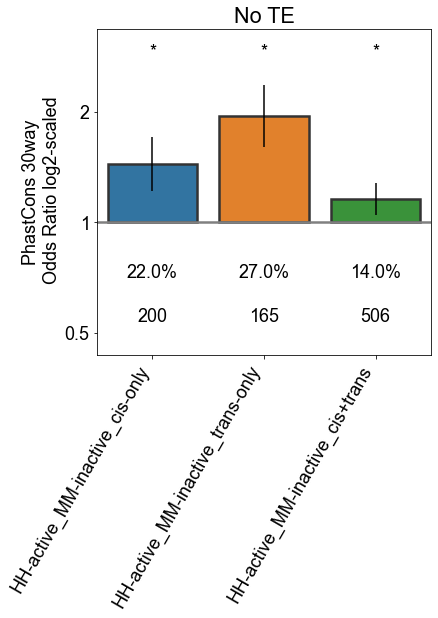

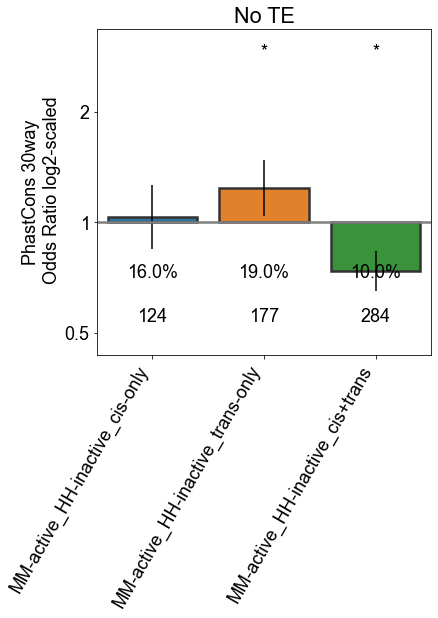

In [41]:
for key, value in plot_sets.items():
    print(value)
 
    x,y ="comparison", "OR_log2"
    
    data = fdr.loc[fdr["comparison"].isin(value)]
    data = data.set_index("comparison")
    data = data.loc[value].reset_index()
    ci_upper, ci_lower= "ci_upper_log2","ci_lower_log2"

    ytick_multiple = 1
    ylim = (-1.2,1.75)
    title = "No TE"#f"{key}"

    hue = None
    if key == "main_fig_all":
        figsize = (10,6)
    else:
        figsize=None

    # plot
    fig, ax = plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title, figsize)

    ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, horizontalalignment = "right")
    ax.set( ylabel = "PhastCons 30way\n Odds Ratio log2-scaled"
        #xticklabels = ["Conserved activity", "Trans", "Cis", "Cis and trans"]
    )
    plotc = data["a"].astype(int)
    annotate_bar(ax, "x", plotc, -0.9)
    plota = data["asterisks"]
    annotate_bar(ax, "x", plota, 1.5)
    plota = data["frac"].round(2).apply(lambda x: str(round(x*100, 2))+"%")
    annotate_bar(ax, "x", plota, -0.5)

    outf = os.path.join(RE, f"phastCons_enrichment_{key}_v_10x_shuffle_validation_NO_TE.pdf")

    plt.savefig(outf, bbox_inches = "tight")